In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv('BankRecords.csv')

In [3]:
data.head()

ID  Age  Experience(Years)  Income(Thousands's)  Sort Code  Family  \
0   1   25                  1                   49      91107       4   
1   2   45                 19                   34      90089       3   
2   3   39                 15                   11      94720       1   
3   4   35                  9                  100      94112       1   
4   5   35                  8                   45      91330       4   

   Credit Score Education  Mortgage(Thousands's) Personal Loan  \
0           1.6   Diploma                      0            No   
1           1.5   Diploma                      0            No   
2           1.0   Diploma                      0            No   
3           2.7    Degree                      0            No   
4           1.0    Degree                      0            No   

  Securities Account CD Account Online Banking CreditCard  
0                Yes         No             No         No  
1                Yes         No             No         No  
2                 No         No             No         No  
3                 No         No             No         No  
4                 No         No             No        Yes

* Dropping ID as it could be read by the model as ordinal, as if it has some mathematic significance.

In [4]:
data.drop('ID', axis=1, inplace = True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    5000 non-null   int64  
 1   Experience(Years)      5000 non-null   int64  
 2   Income(Thousands's)    5000 non-null   int64  
 3   Sort Code              5000 non-null   int64  
 4   Family                 5000 non-null   int64  
 5   Credit Score           5000 non-null   float64
 6   Education              5000 non-null   object 
 7   Mortgage(Thousands's)  5000 non-null   int64  
 8   Personal Loan          5000 non-null   object 
 9   Securities Account     5000 non-null   object 
 10  CD Account             5000 non-null   object 
 11  Online Banking         5000 non-null   object 
 12  CreditCard             5000 non-null   object 
dtypes: float64(1), int64(6), object(6)
memory usage: 507.9+ KB


In [6]:
data.isna().sum()

Age                      0
Experience(Years)        0
Income(Thousands's)      0
Sort Code                0
Family                   0
Credit Score             0
Education                0
Mortgage(Thousands's)    0
Personal Loan            0
Securities Account       0
CD Account               0
Online Banking           0
CreditCard               0
dtype: int64

* No null values.
* Object types to be encoded.

In [7]:
data.describe()

Age  Experience(Years)  Income(Thousands's)     Sort Code  \
count  5000.000000        5000.000000          5000.000000   5000.000000   
mean     45.338400          20.104600            73.774200  93152.503000   
std      11.463166          11.467954            46.033729   2121.852197   
min      23.000000          -3.000000             8.000000   9307.000000   
25%      35.000000          10.000000            39.000000  91911.000000   
50%      45.000000          20.000000            64.000000  93437.000000   
75%      55.000000          30.000000            98.000000  94608.000000   
max      67.000000          43.000000           224.000000  96651.000000   

            Family  Credit Score  Mortgage(Thousands's)  
count  5000.000000   5000.000000            5000.000000  
mean      2.396400      1.937913              56.498800  
std       1.147663      1.747666             101.713802  
min       1.000000      0.000000               0.000000  
25%       1.000000      0.700000               0.000000  
50%       2.000000      1.500000               0.000000  
75%       3.000000      2.500000             101.000000  
max       4.000000     10.000000             635.000000

* Some wrong values in Experience as it cannot be negative in real life.
* Some extreme values present in income as evident fromt he difference in max and 75%.
* Evident using Boxplot.

In [8]:
data.loc[data['Experience(Years)'] < 0, 'Experience(Years)'] = 0

* Encoding yes and no to 1 and 0 respectively.

In [9]:
data.replace({'Yes': 1, 'No': 0}, inplace=True)

* One hot encoding for education as it is a low cardinality feature and will not effect sparsity of the data.

In [10]:
data = pd.get_dummies(data, columns=['Education'], dtype=int)

In [11]:
data.head()

Age  Experience(Years)  Income(Thousands's)  Sort Code  Family  \
0   25                  1                   49      91107       4   
1   45                 19                   34      90089       3   
2   39                 15                   11      94720       1   
3   35                  9                  100      94112       1   
4   35                  8                   45      91330       4   

   Credit Score  Mortgage(Thousands's)  Personal Loan  Securities Account  \
0           1.6                      0              0                   1   
1           1.5                      0              0                   1   
2           1.0                      0              0                   0   
3           2.7                      0              0                   0   
4           1.0                      0              0                   0   

   CD Account  Online Banking  CreditCard  Education_Degree  \
0           0               0           0                 0   
1           0               0           0                 0   
2           0               0           0                 0   
3           0               0           0                 1   
4           0               0           1                 1   

   Education_Diploma  Education_Masters  
0                  1                  0  
1                  1                  0  
2                  1                  0  
3                  0                  0  
4                  0                  0

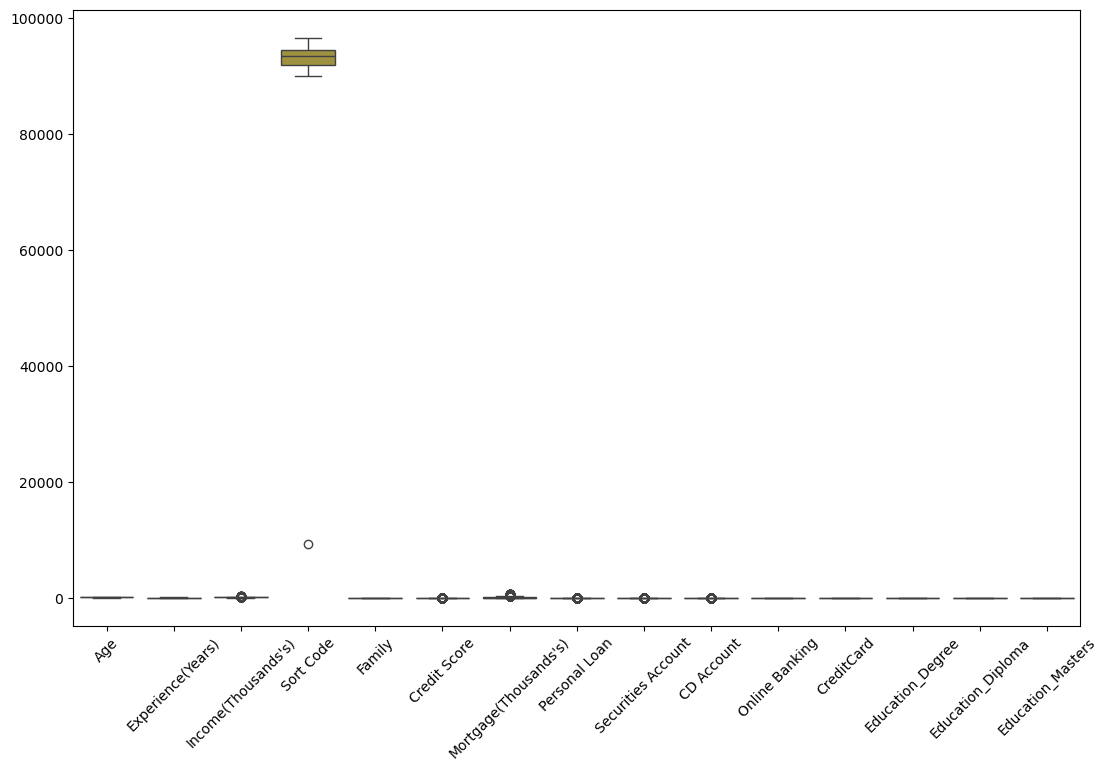

In [12]:
plt.figure(figsize=(13, 8))
sns.boxplot(data=data)
plt.xticks(rotation=45)
plt.show()

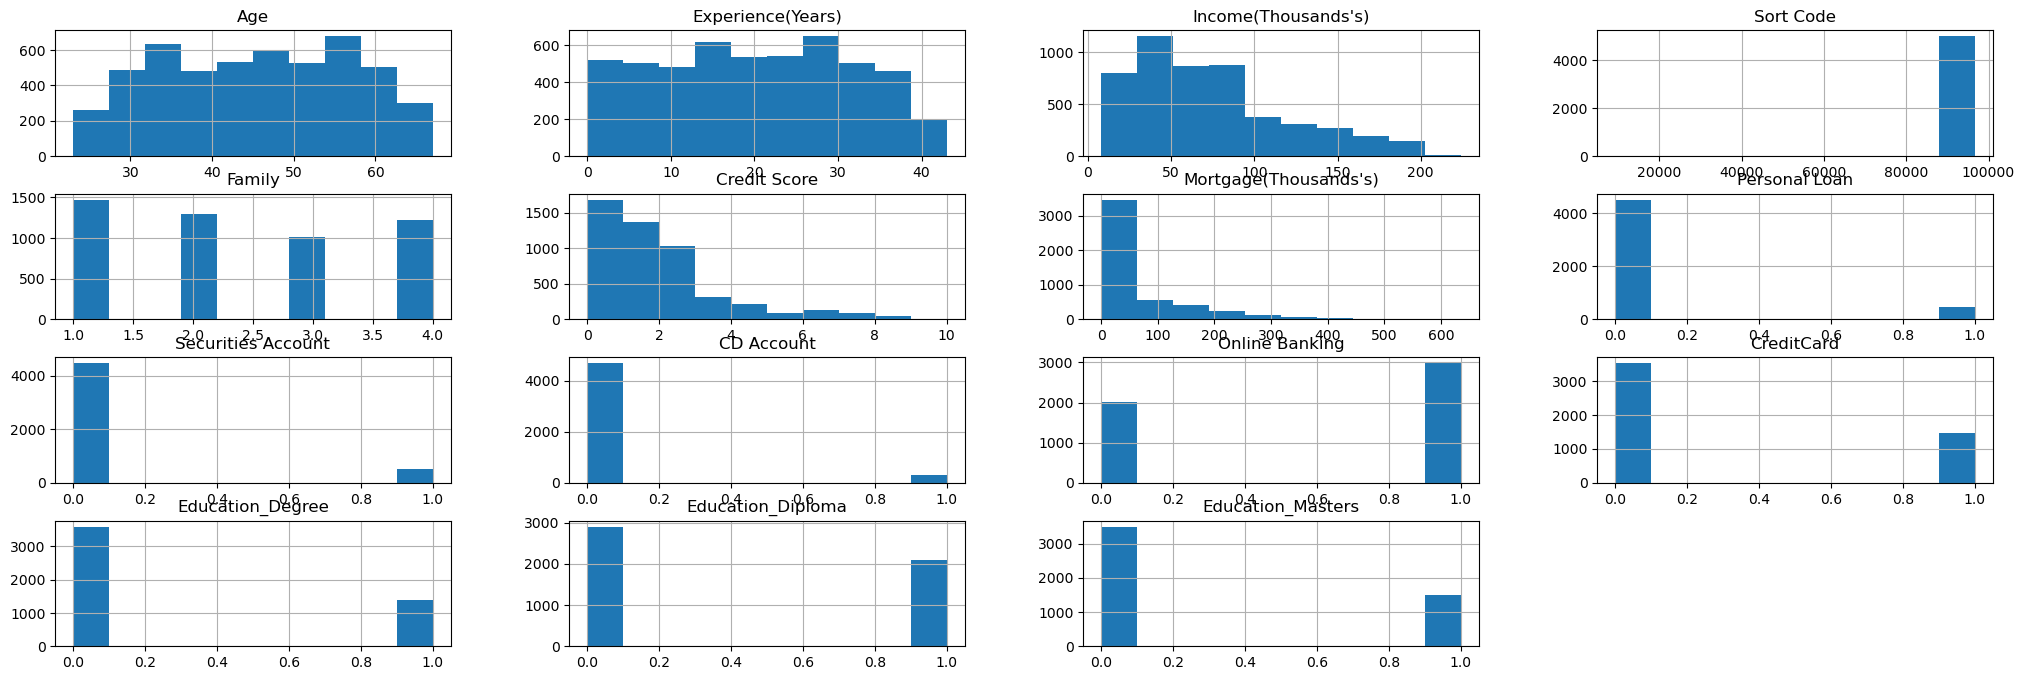

In [13]:
data.hist(figsize=(25,8));

* Data such as Sort Code, Credit Score and Mortgage right skewed, we can use log to transform these.
* Using log increased accuracy by 3%

In [14]:
data["Mortgage(Thousands's)"] = np.log1p(data["Mortgage(Thousands's)"])
data["Credit Score"] = np.log1p(data["Credit Score"])
data["Sort Code"] = np.log1p(data["Sort Code"])

In [15]:
def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared
evals = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score"])

In [16]:
X = data.drop("Income(Thousands's)", axis=1)
y = data["Income(Thousands's)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Used SelectKBest as it provides the best possible subset of features for predicting the target.
* Accuracy increased by using feature selection.

In [17]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k=10)

fs.fit_transform(X_train, y_train)
cols_from_k=X_train.columns[fs.get_support(indices=True)]

X_train = X_train[cols_from_k]
X_test = X_test[cols_from_k]

* Scaling data to reduce the span of data
* Scaling is required by both model deisgns used.
* Used a Standard scaler as the scale of features is quite different from each other.
* MinMaxScaler increased the accuracy in Neural networks but reduced performance in regressors.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

* Used Random forest regressor as it is evident that using a different subset gives a different result.
* Therefore, Random forest provides the ability through trees using different subsets of features, hence increasing accuracy.
* Random forest is robust to overfitting.
* It is robust to outliers as well, as ourt data contains some extreme values that were scaled down, random forest is the best option.

In [19]:
regressor = RandomForestRegressor()
regressor.fit(X_train_s, y_train)

y_pred_reg = regressor.predict(X_test_s)

In [20]:
mae_reg, mse, rmse, r_squared_reg = evaluation(y_test, y_pred_reg)
print("MAE:", mae_reg)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared_reg)
print("-"*30)

MAE: 13.50005650108225
MSE: 364.60463304206917
RMSE: 19.094623144803595
R2 Score: 0.8280589316919802
------------------------------


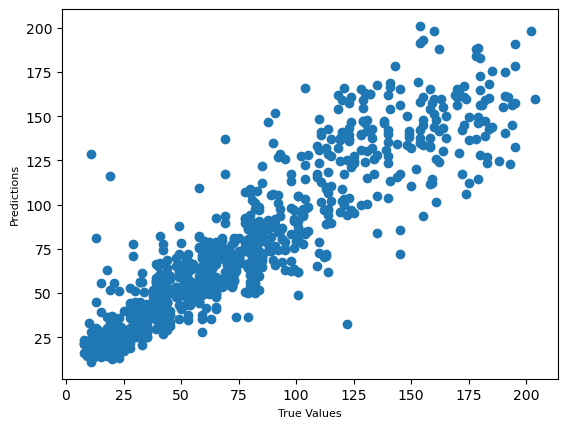

In [21]:
plt.scatter(y_test, y_pred_reg)
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.show()

In [22]:
new_row = {"Model": "Random Forest","MAE": mae_reg, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared_reg}
evals = pd.concat([evals, pd.DataFrame([new_row])], ignore_index=True)

C:\Users\Ali\AppData\Local\Temp\ipykernel_27828\3735654929.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evals = pd.concat([evals, pd.DataFrame([new_row])], ignore_index=True)


In [23]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train_s, y_train)

best_regressor = grid_search.best_estimator_
best_regressor.fit(X_train_s, y_train)

y_pred_hpt = best_regressor.predict(X_test_s)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [24]:
mae_hpt, mse, rmse, r_squared_hpt = evaluation(y_test, y_pred_hpt)
print("MAE:", mae_hpt)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared_hpt)
print("-"*30)

MAE: 13.641355362393849
MSE: 370.16265820936417
RMSE: 19.23961169590915
R2 Score: 0.8254378657527625
------------------------------


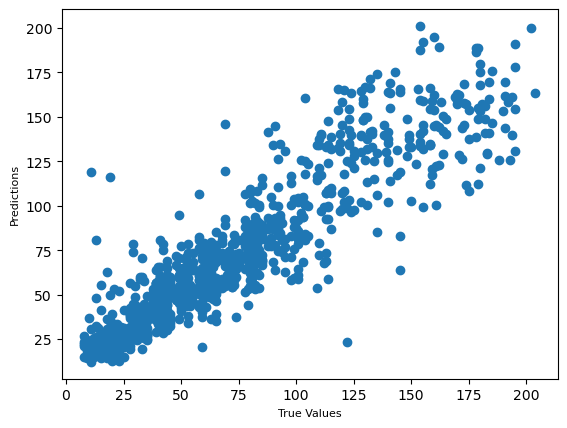

In [25]:
plt.scatter(y_test, y_pred_hpt)
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.show()

In [26]:
new_row = {"Model": "Random Forest - HPT","MAE": mae_hpt, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared_hpt}
evals = pd.concat([evals, pd.DataFrame([new_row])], ignore_index=True)

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam 

model_base = Sequential() 
model_base.add(Dense(120, activation='relu', 
kernel_initializer='he_uniform')) 
model_base.add(Dense(1, activation='linear')) 
#opt = SGD(learning_rate=1.0, momentum=0.6) 
opt = Adam()
model_base.compile(loss='mean_squared_logarithmic_error', optimizer=opt, 
metrics=['mse']) 

model_base.fit(X_train_s, y_train, validation_data=(X_test_s, y_test), 
epochs=300, verbose=0) 

In [28]:
y_pred_nn = model_base.predict(X_test_s)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


In [29]:
mae_nn, mse, rmse, r_squared_nn = evaluation(y_test, y_pred_nn)
print("MAE:", mae_nn)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared_nn)
print("-"*30)

MAE: 20.261703536987305
MSE: 726.2038572320535
RMSE: 26.948169830844794
R2 Score: 0.6575351608121867
------------------------------


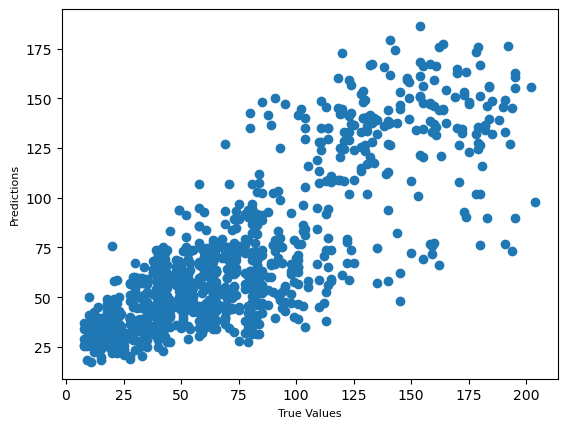

In [30]:
plt.scatter(y_test, y_pred_nn)
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.show()

In [31]:
new_row = {"Model": "Neural Net - Baseline","MAE": mae_nn, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared_nn}
evals = pd.concat([evals, pd.DataFrame([new_row])], ignore_index=True)

In [32]:
model_deep = Sequential() 
model_deep.add(Dense(200, activation='relu',kernel_initializer='he_uniform'))
model_deep.add(Dense(100, activation='relu',kernel_initializer='he_uniform')) 
model_deep.add(Dense(1, activation='linear')) 

#opt = SGD(learning_rate=1.0, momentum=0.6) 
opt = Adam()

model_deep.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mse']) 

model_deep.fit(X_train_s, y_train, validation_data=(X_test_s, y_test), 
epochs=300, verbose=0) 

In [33]:
y_pred_nn = model_deep.predict(X_test_s)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


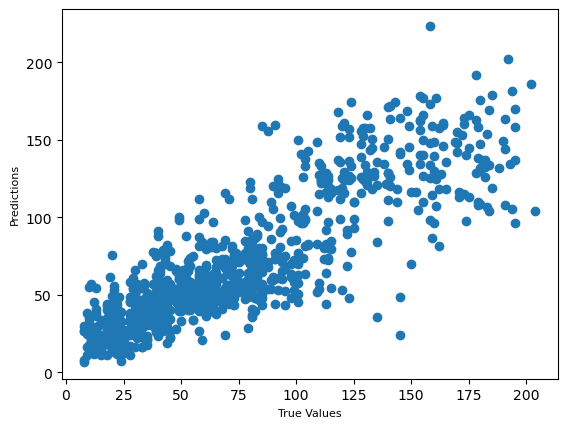

In [34]:
plt.scatter(y_test, y_pred_nn)
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.show()

In [35]:
mae_nn, mse, rmse, r_squared_nn = evaluation(y_test, y_pred_nn)
print("MAE:", mae_nn)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared_nn)
print("-"*30)

MAE: 17.68774784564972
MSE: 589.075129188746
RMSE: 24.270869971814896
R2 Score: 0.7222026330786888
------------------------------


In [36]:
new_row = {"Model": "Neural Net - Deep","MAE": mae_nn, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared_nn}
evals = pd.concat([evals, pd.DataFrame([new_row])], ignore_index=True)

In [37]:
model_wide = Sequential() 
model_wide.add(Dense(200, activation='relu',kernel_initializer='he_uniform')) 
model_wide.add(Dense(1, activation='linear')) 

#opt = SGD(learning_rate=1.0, momentum=0.6) 
#opt = Adam(learning_rate= 0.006)
opt = Adam()

model_wide.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mse']) 

model_wide.fit(X_train_s, y_train, validation_data=(X_test_s, y_test), 
epochs=300, verbose=0) 

In [38]:
y_pred_nnw = model_wide.predict(X_test_s)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


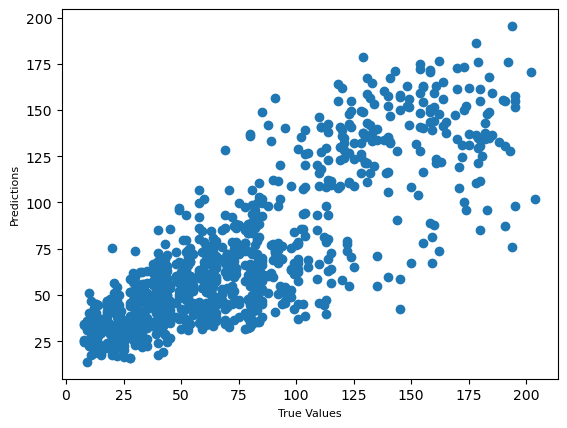

In [39]:
plt.scatter(y_test, y_pred_nnw)
plt.xlabel('True Values', fontsize=8)
plt.ylabel('Predictions', fontsize=8)
plt.show()

In [40]:
mae_nn, mse, rmse, r_squared_nn = evaluation(y_test, y_pred_nnw)
print("MAE:", mae_nn)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared_nn)
print("-"*30)

MAE: 19.552226857185364
MSE: 680.8269038591901
RMSE: 26.092659961360592
R2 Score: 0.6789341259717794
------------------------------


In [41]:
new_row = {"Model": "Neural Net - Wide","MAE": mae_nn, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared_nn}
evals = pd.concat([evals, pd.DataFrame([new_row])], ignore_index=True)

* We can see that Random forest with Hyper parameter tuning works best.
* Neural networks are not suited for this problem as the dataset is quite small and simple.
* Neural networks were running into overfitting to training data.

In [42]:
evals.sort_values(by="RMSE")

Model        MAE         MSE       RMSE  R2 Score
0          Random Forest  13.500057  364.604633  19.094623  0.828059
1    Random Forest - HPT  13.641355  370.162658  19.239612  0.825438
3      Neural Net - Deep  17.687748  589.075129  24.270870  0.722203
4      Neural Net - Wide  19.552227  680.826904  26.092660  0.678934
2  Neural Net - Baseline  20.261704  726.203857  26.948170  0.657535

* Checking columns that were used for the models.

In [43]:
cols_from_k

Index(['Age', 'Experience(Years)', 'Family', 'Credit Score',
       'Mortgage(Thousands's)', 'Personal Loan', 'CD Account',
       'Education_Degree', 'Education_Diploma', 'Education_Masters'],
      dtype='object')

* Making a prediction using random data by using the most accurate model from the above chart.

In [44]:
test_object = {
    "Age": 45,
    "Experience(Years)": 20,
    "Family": 4,
    "Credit Score": 1.4,
    "Mortgage(Thousands)": 150.75,
    "Personal Loan": 0,
    "CD Account": 1,
    "Education_Degree": 1,
    "Education_Diploma": 0,
    "Education_Masters": 1
}

test = pd.DataFrame([test_object])

In [45]:
best_regressor.predict(test.values)

array([137.74])